## Importing all required Modules

In [0]:
#all imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile, os, warnings, joblib, import_ipynb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import log_loss
warnings.filterwarnings('ignore')

## Data Preparation and Feature extraction

In [0]:
# csv files path
train_path='train_users.csv'
test_path='test_users.csv'
sess_path='sessions.csv'

# data_path dictionary
Data_path={"train":train_path,"test":test_path,"session":sess_path}

from Data_Preparation_Airbnb import Data_Preparation
Prepared_Data, target_labels=Data_Preparation(Data_path,Invoke_by_module=True)

importing Jupyter notebook from Data_Preparation_Airbnb.ipynb
Data_Preparation Module
1.Reading Csv Files    .. .. .. >>> |Done| <1/5>
2.Preprocessing Data   .. .. .. >>> |Done| <2/5>
3.Extracting Features  .. .. .. >>> |Done| <3/5>
4.Formatting Data      .. .. .. >>> |Done| <4/5>
5.Returning Final Data .. .. .. >>> |Done| <5/5>


## Feature Selection

In [0]:
from Data_Preparation_Airbnb import Feature_Selection 
Data, Selected_Features=Feature_Selection(Prepared_Data, target_labels,Keep_percent=0.7, kag_sub=True, Rerun=False)

Feature Selection
1.Performing Train Validation split on Data .. .. .. >>> |Done| <1/3>
2.Training Xgboost for Feature Importance   .. .. .. >>> |Done| <2/3>
3.Returning Selected Features               .. .. .. >>> |Done| <3/3>
Selected 462 Important Features from 661 Features


## Train_Validation split and Standardization

In [0]:
# Perform Train_val_splits # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Train_x, CV_x, Train_y, CV_y, Test_x, Test_id, lab_en = Data[0],Data[1],Data[2],Data[3],Data[4],Data[5],Data[6]

# Standardization 
Std_Scl = StandardScaler()
Train_x = Std_Scl.fit_transform(Train_x)
CV_x = Std_Scl.transform(CV_x)

## printing size of train_val_data
print('Train_x and Train_y : ({},{})'.format(Train_x.shape, Train_y.shape))
print(' Val_x  and Val_y   : ({},{})'.format(CV_x.shape, CV_y.shape))

Train_x and Train_y : ((170760, 462),(170760,))
 Val_x  and Val_y   : ((42691, 462),(42691,))


## NDCG Scorer Function

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
# DCG Scorer function setup
def dcg_score(y_true, y_score, k=5):
    
    """
    Compute DCG@k Score for an input
    
    parameters
    ----------
    y_true <ndarray>  : correct relevance values  
    y_score <ndarray> : predicted scores
    k <int>           : rank
    
    returns
    -------
    dcg_score <float> : DCG@5 score
    
    """ 
    
    # Compute releveace values for predictions
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    # compute DCG@k for a given point
    dcg_numerator   = 2 ** y_true - 1
    dcg_denominator = np.log2( np.arange( len(y_true) ) + 2 )
    dcg_score = np.sum( dcg_numerator / dcg_denominator )
    
    return dcg_score

# NDCG Scorer function setup
def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Compute NDCG@k Score for given inputs
    
    parameters
    ----------
    ground_truth <ndarray>  : True Class labels  
    predictions <ndarray>   : Predicted probabilities
    k <int>                 : Rank
    
    returns
    -------
    ndcg_score <float> : NDCG@5 score
    """    
    
    # Compute relevance values for ground_truth
    T =  LabelBinarizer().fit(range(predictions.shape[1] + 1)).transform(ground_truth)
    
    # Compute NDCG@k score for all samples
    scores = []
    for y_true, y_score in zip(T, predictions):
        
        dcg_k = dcg_score( y_true, y_score, k)
        idcg_k = dcg_score( y_true, y_true, k)
        ndcg_k = float(dcg_k) / float(idcg_k)
        scores.append(ndcg_k)
        
    # Mean of all scores
    ndcg_score=np.mean(scores)
    
    return ndcg_score

## XG-Boost with Early Stopping 

In [0]:
# https://stackoverflow.com/questions/34674797/xgboost-xgbclassifier-defaults-in-python
# XG-Boost trained with Early Stopping 
xgb = XGBClassifier(n_estimators=8000,objective='multi:softprob',max_depth=6,n_jobs=6,subsample=0.7,reg_lambda=1.0,
                    learning_rate=0.01,min_child_weight=1.0,colsample_bytree=0.7, max_delta_step=5.0,reg_alpha=0.0,
                                            gamma=1.0,verbose=2,seed=0)

# fit model
eval_set=[(Train_x, Train_y), (CV_x, CV_y)]
xgb.fit(Train_x, Train_y, eval_set=eval_set, eval_metric ="mlogloss", early_stopping_rounds=25, verbose=120)    

# evalute model 
y_valid_pred = xgb.predict_proba(CV_x)
val_score=ndcg_score(CV_y, y_valid_pred, k=5)
val_loss = log_loss(CV_y, y_valid_pred)

# print scores
print("NDCG_Score: {}".format(np.round(val_score,5)))
print("Logloss   : {}".format(np.round(val_loss,5)))

[0]	validation_0-mlogloss:2.45732	validation_1-mlogloss:2.45759
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 25 rounds.
[120]	validation_0-mlogloss:1.35114	validation_1-mlogloss:1.36007
[240]	validation_0-mlogloss:1.11921	validation_1-mlogloss:1.13538
[360]	validation_0-mlogloss:1.0415	validation_1-mlogloss:1.06508
[480]	validation_0-mlogloss:1.00837	validation_1-mlogloss:1.03974
[600]	validation_0-mlogloss:0.989947	validation_1-mlogloss:1.02943
[720]	validation_0-mlogloss:0.977309	validation_1-mlogloss:1.02489
[840]	validation_0-mlogloss:0.967256	validation_1-mlogloss:1.02258
[960]	validation_0-mlogloss:0.95859	validation_1-mlogloss:1.02132
[1080]	validation_0-mlogloss:0.950613	validation_1-mlogloss:1.0206
[1200]	validation_0-mlogloss:0.943298	validation_1-mlogloss:1.0202
[1320]	validation_0-mlogloss:0.936355	validation_1-mlogloss:1.01994
[1440]	validation_0-mlogloss:0.929811

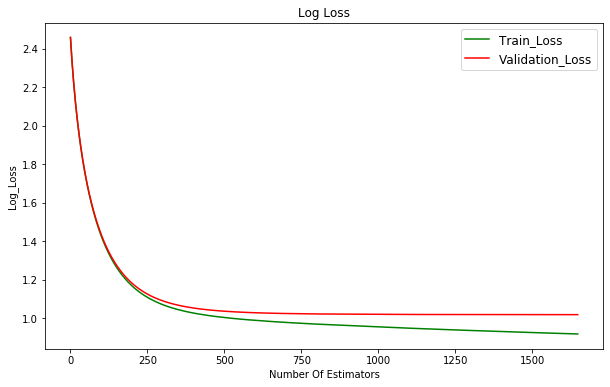

In [0]:
# plot Train and Validation loss
evals_result1=xgb.evals_result_["validation_0"]["mlogloss"] #train_loss
evals_result2=xgb.evals_result_["validation_1"]["mlogloss"] #test_loss

# plot_figure
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(evals_result1)), evals_result1, label="Train_Loss", color="green")
plt.plot(np.arange(len(evals_result2)), evals_result2, label="Validation_Loss", color="red")
plt.xlabel("Number Of Estimators")
plt.ylabel("Log_Loss")
plt.title("Log Loss")
plt.legend(prop={'size': 12})
plt.show()

importing Jupyter notebook from Data_Preparation_Airbnb.ipynb


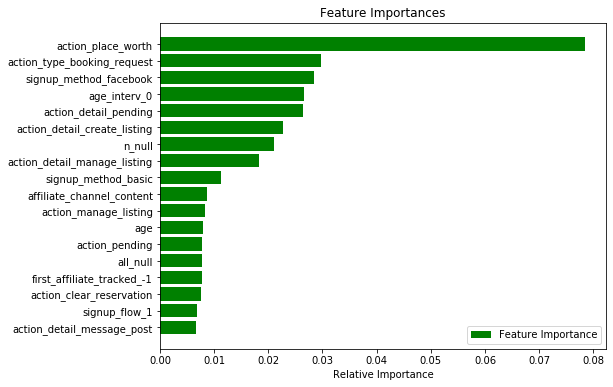

{0: 'action_place_worth',
 1: 'action_type_booking_request',
 2: 'signup_method_facebook',
 3: 'age_interv_0',
 4: 'action_detail_pending',
 5: 'action_detail_create_listing',
 6: 'n_null',
 7: 'action_detail_manage_listing',
 8: 'signup_method_basic',
 9: 'affiliate_channel_content',
 10: 'action_manage_listing',
 11: 'age',
 12: 'action_pending',
 13: 'all_null',
 14: 'first_affiliate_tracked_-1',
 15: 'action_clear_reservation',
 16: 'signup_flow_1',
 17: 'action_detail_message_post'}

In [0]:
# Get Important Features 
from Data_Preparation_Airbnb import Get_Imp_Features
Imp_Features = Get_Imp_Features(Model=xgb, Top=18, Want_to_load=False)
Imp_Features_dict = { i : Imp_Features[i] for i in range(0, len(Imp_Features) ) }
Imp_Features_dict

In [0]:
import joblib
joblib.dump("xgb2_best_8000") # save model

['xgb2_best_8000']


## Kaggle Submission File

In [0]:
# predict_proba for Test_data from kaggle 
prediction_proba=xgb.predict_proba(ntree_limit=xgb.best_iteration, data=Std_Scl.transform(Test_x))

# get test_id
ids_test = Test_id.ravel()

ids = []
countries = []

# preparing submission data_frame 
for i in range(len(ids_test)):
    idx = ids_test[i]
    ids += [idx] * 5
    countries += lab_en.inverse_transform(np.argsort(prediction_proba[i])[::-1][:5]).tolist()
submission = pd.DataFrame({"id" : ids,"country" : countries})

# submission file    
submission.to_csv('Kag_submission.csv', index = False)
print("Submission File Successfully Generated")

Submission File Successfully Generated


# Final Kaggle Score [Among Top 3% on Public LeaderBoard]

<img src='https://imgur.com/bGELGT1.png'>
ref: https://imgur.com/bGELGT1